If you wish to use Drive functionalities, please make sure Drive is mounted. Click *Mount Drive* under Files in the left-side menu, or run the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Libraries, classes and functions

## Libraries

In [ ]:
try:
 import transformers
except:
 print("Installing transformers")
 !pip3 install transformers

try:
  import datasets
except:
  print("Installing datasets")
  !pip3  install datasets


#try:
#  import evaluate
#except:
#  print("Installing evaluate")
#  !pip3 -q install evaluate

Installing datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00


In [ ]:
#System
import io
import os.path

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Hugging Face
from transformers import AutoTokenizer, DataCollatorWithPadding#, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler, set_seed
from transformers import logging
#from transformers import Trainer, TrainingArguments
logging.set_verbosity_error()
from datasets import Dataset, load_dataset, load_metric, load_from_disk
from datasets import interleave_datasets, concatenate_datasets


#Torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch import autocast

#Data structures
import numpy as np
import pandas as pd
from pandas import read_pickle

#Math functions
import random
from math import ceil

#Loading bars
from tqdm.auto import tqdm

#Plotting
import matplotlib.pyplot as plt

In [ ]:
#Custom Evaluate class provided by Yupei Du. Modified by Pim Versteeg.
#Replaces the evaluate library due to problems with it.

from sklearn.metrics import accuracy_score, f1_score

class Evaluate:

    def __init__(self, metric_name):
        r"""https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#e273"""
        self.metric_name = metric_name
        self.predictions = None
        self.references = None

    def add_batch(self, predictions, references):
        predictions = predictions.detach().cpu()
        references = references.detach().cpu()
        self.predictions = predictions if self.predictions is None \
            else torch.cat([self.predictions, predictions], dim=0)
        self.references = references if self.references is None else torch.cat([self.references, references], dim=0)

    @staticmethod
    def _keep_three_digits(number):
        return float('{:.3f}'.format(number))

    def compute(self, average='macro'):
        if self.metric_name == 'accuracy':
            return {'accuracy': self._keep_three_digits(accuracy_score(self.references, self.predictions))}
        elif self.metric_name == 'f1':
            return {'f1': self._keep_four_digits(f1_score(self.references, self.predictions, average=average))}


def load(metric_name):
    if metric_name in ['accuracy', 'f1']:
        return Evaluate(metric_name)
    else:
        raise ValueError(f'Unknown metric name {metric_name}')

## Preprocessing

Functions for preprocessing:

1. `load_data` loads a `GLUE` dataset. If `size=full` or is unspecified, it returns the full data set. `size=int` trims the `train` partition to the length of that integer.
2. `select_baseline` takes a dataset and returns a random subset to the data of size `fraction * len(dataset)`. If `criterium` is not `None`, select according to criterium. Eg: `fraction=0.33` and `criterium=hard` returns the hardest 33% of the data.
3. `select_criterium` is a helper function for `select_baseline` and should not be called directly.
3. `data_cleaner` converts a dataset to the correct format for training.
4. `normalize_probs` takes a 2D-array (list of lists) and for each row normalizes the values to sum to 1.
5. `find_max_token_length` takes a dataset and returns the max token length. Works on split(`train`,`validation`,`test` etc) datasets.

In [ ]:
def load_data(load_path, size='full'):
  if type(load_path) is tuple:
    #For GLUE datasets
    raw_data = load_dataset(load_path[0],load_path[1])
  else:
    #For non-GLUE datasets
    raw_data = load_dataset(load_path)
  if size != 'full':
    raw_data["train"]= raw_data["train"].select(range(size))
  return raw_data


def select_baseline(data, fraction, seed, criterium):
  if criterium==None:
    return data.select(range(int(fraction*len(data))))
  else:
    return select_criterium(data, scores, fraction, criterium)


def select_criterium(data, scores, fraction, criterium):
  #ambiguous_scores: variability        -> higher variability = more ambiguous
  #hard_scores: confidence but negative -> closer to zero = higher = lower confidence = harder.
  ambiguous_scores, hard_scores = scores
  scores = ambiguous_scores if criterium=='ambiguous' else hard_scores
  data_w_scores = data.add_column(name='scores', column=scores.tolist())

  desc = criterium in ['hard','ambiguous']
  sorted_data = data_w_scores.sort(['scores'], reverse=desc)
  sorted_data = sorted_data.remove_columns('scores')
  return sorted_data.select(range(int(fraction*len(data)))).shuffle()


def data_cleaner(data):
  data = data.remove_columns([data_args['str_name_1'], data_args['str_name_2'],"idx"])
  data = data.rename_column("label", "labels")
  data = data.filter(lambda x: x['labels'] in [0,1,2])
  data.set_format("torch")
  return data

def data_cleaner_ood(data):
  data = data['test']
  data = data.remove_columns(list(data.features.keys())[:-3])
  data = data.rename_column('label', 'labels')
  data.set_format('torch')
  return data



def normalize_probs(arr):
  for i in range(len(arr)):
    arr[i] = [x/sum(arr[i]) for x in arr[i]]
  return arr


def find_max_token_length(data):
  total_max = 0
  for k in tokenized_data.keys():
    longest = max(tokenized_data[k]['input_ids'], key=len)
    max = len(longest)
    if max > total_max:
      total_max = longest
  return total_max

## Administrative functions

In [ ]:
def generate_experiment_name():
  if experiment_args['baseline']:
    if base_args['criterium']:
      return data_args['name'] + '_baseline_' + base_args['criterium'] + str(int(base_args['fraction']*100))
    else:
      return data_args['name'] + '_baseline_' + str(int(base_args['fraction']*100))
  else:
    if curr_args['banking']:
      return data_args['name'] + '_scl_' + curr_args['tactic'] + str(int(curr_args['threshold']*100)) + '_bank'
    else:
      return data_args['name'] + '_scl_' + curr_args['tactic'] + str(int(curr_args['threshold']*100))

## Data maps pipeline

In [ ]:
def compute_data_map_scores(logits_list, labels):
#Function provided by Yupei Du.
#ambiguous_scores: higher = more ambiguous
#hard_scores: confidence but negative. closer to zero = lower confidence = harder.
    prob = torch.stack(logits_list, dim=0).softmax(dim=-1)
    conf = torch.gather(prob, 2, labels[(None,) + (...,) + (None,)].expand_as(prob))[:, :, 0]
    ambiguous_scores, hard_scores = torch.std(conf, dim=0), -torch.mean(conf, dim=0)
    return ambiguous_scores, hard_scores

In [ ]:
def dm_pipeline(tokenized_data, data_collator):
  train_dataloader = DataLoader(
    tokenized_data[data_args['train_name']], shuffle=True, batch_size=model_args['batch_size'], collate_fn=data_collator
  )
  train_dataloader_unshuffled = DataLoader(
    tokenized_data[data_args['train_name']], shuffle=False, batch_size=model_args['batch_size'], collate_fn=data_collator
  )

  num_epochs = model_args['num_epochs']
  num_training_steps = num_epochs * len(train_dataloader_unshuffled)     #Length dataloader is number of batches in it. So a training step is everytime a batch is used for training.
  num_warmup_steps = model_args['num_warmup_steps']
  lr = 5e-5

  model = AutoModelForSequenceClassification.from_pretrained(model_args['checkpoint'], num_labels=data_args['num_labels'])
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)

  optimizer = AdamW(model.parameters(), lr=model_args['learning_rate'])
  scaler = GradScaler()
  lr_scheduler = get_scheduler(
    model_args['lr-schedule'],
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
  )

  progress_bar = tqdm(range(num_training_steps))

  logits_list= [None]*num_epochs #n-th entry in the list corresponds to the n+1th epoch

  model.train()
  for epoch in range(num_epochs):
    logits_list[epoch] = torch.empty(0, data_args['num_labels'])
    for batch in train_dataloader_unshuffled:
      batch = {k: v.to(device) for k, v in batch.items()}
      with autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(**batch)
        loss = outputs.loss
      scaler.scale(loss).backward()

      scaler.step(optimizer)
      lr_scheduler.step()
      optimizer.zero_grad()
      scaler.update()
      progress_bar.update(1)

      logits_list[epoch] = torch.cat((logits_list[epoch],outputs.logits.to('cpu').detach()))

  gold_labels = torch.LongTensor(tokenized_data[data_args['train_name']]['labels'])
  ambiguous_scores, hard_scores = compute_data_map_scores(logits_list, gold_labels)

  return model, (ambiguous_scores, hard_scores)

## Curriculum class

Note: 'chunks' in the code are synonymous to 'buckets' in the thesis report.

In [ ]:
class Curriculum:
  def __init__(self, data, scores, data_collator):
    self.data = data
    self.ambiguous_scores, self. hard_scores = scores
    self.data_collator = data_collator

    self.batch_size = model_args['batch_size']
    self.num_epochs = model_args['num_epochs']
    self.tactic = curr_args['tactic']
    self.num_chunks = curr_args['num_chunks']

    self.sort()       #Sort data according to 'tactic'.
    self.chunk()      #Chunk data into num_chunks chunks.


  def sort(self):
    # tactic ∈ ['easy','hard','ambiguous']
    # 'easy' is easy to hard, 'hard' is hard to easy, 'ambiguous' is from least to most ambiguous
    scores = self.ambiguous_scores if self.tactic=='ambiguous' else self.hard_scores
    data_w_scores = self.data.add_column(name='scores', column=scores.tolist())

    desc = self.tactic=='hard'
    sorted_data = data_w_scores.sort(['scores'], reverse=desc)
    sorted_data = sorted_data.remove_columns('scores')
    self.data = sorted_data

  def chunk(self):
    chunks = []
    size = ceil(len(self.data) / self.num_chunks)
    for i in range(self.num_chunks):
      subset = Dataset.from_dict(self.data[i*size : i*size+size])
      chunks.append(subset)
    self.data = chunks


  def drop_chunk(self):
    if len(self.data) > 1:
      self.data = self.data[1:]

  def peek_chunk(self):
    return self.data[0]

  def get_chunk(self, c):
    return self.data[c]

  def get_n_chunks(self):
    return len(self.data)

  def create_adaptive_curriculum(self):
    return DataLoader(concatenate_datasets(self.data).shuffle(), batch_size=self.batch_size, collate_fn=self.data_collator)

  #These functions were used in an earlier form of curriculum learning, but now are no longer used.
  def for_epoch(self, e):
    return self.per_epoch[e]

  def map_curr(self):
    lst = [None]*self.num_epochs
    for e in range(self.num_epochs):
      nonzero_chunks = [self.data[x] for x in range(self.num_epochs) if self.curriculum[e][x] != 0]
      nonzero_curriculum = [x for x in self.curriculum[e] if x != 0]
      lst[e] = interleave_datasets(nonzero_chunks, probabilities=nonzero_curriculum, stopping_strategy="first_exhausted")
    self.per_epoch = lst

## SCL pipeline

In [ ]:
def scl_pipeline(tokenized_data, tokenized_ood, data_collator, scores, seed):
  #SYNONYMS.
  baseline = experiment_args['baseline']
  banking = curr_args['banking']
  num_epochs = model_args['num_epochs']
  num_chunks = curr_args['num_chunks']
  threshold = curr_args['threshold']
  banking   = curr_args['banking']

  #CREATE DATALOADER OR CURRICULUM OBJECT.
  if baseline:
    train = select_baseline(tokenized_data[data_args['train_name']], base_args['fraction'], seed, base_args['criterium'])
  else:
    curr = Curriculum(tokenized_data['train'], scores, data_collator)
    train = tokenized_data[data_args['train_name']]
  val  = tokenized_data[data_args['val_name']]
  test1 = tokenized_data[data_args['test_name']]
  test2 = tokenized_ood
  train_dl = DataLoader(train, batch_size=model_args['batch_size'], collate_fn=data_collator)
  val_dl   = DataLoader(val,   batch_size=model_args['batch_size'], collate_fn=data_collator)
  test1_dl  = DataLoader(test1,  batch_size=model_args['batch_size'], collate_fn=data_collator)
  test2_dl  = DataLoader(test2,  batch_size=model_args['batch_size'], collate_fn=data_collator)

  #MODEL, OPTIMIZER, LR-SCHEDULER SETUP.
  model = AutoModelForSequenceClassification.from_pretrained(model_args['checkpoint'], num_labels=data_args['num_labels'])
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)

  optimizer = AdamW(model.parameters(), lr=model_args['learning_rate'])
  scaler = GradScaler()

  if baseline or banking:
    lr_scheduler = get_scheduler(
      model_args['lr-schedule'],
      optimizer=optimizer,
      num_warmup_steps=model_args['num_warmup_steps'],
      num_training_steps=num_epochs*len(train_dl),
    )
  else:
    lr_scheduler = LinearLR(
        optimizer,
        start_factor = 1,
        end_factor = 0,
        total_iters= num_epochs-1,
        last_epoch= -1,
      )


  #ACCUMULATORS FOR METRICS AND BATCH COUNT.
  metric_lst = []
  total_batches = 0


  #Accumulator for banking and epochs
  bank = 0
  epoch = 0

  progress_bar = tqdm(range(num_epochs*len(train_dl)))  #Upperbound for nobanking curriculum.
  while epoch < num_epochs or bank > 0:
    print('Epoch '+str(epoch+1), end='')

    #Create adaptive curriculum and do banking.
    if not baseline:
      train_dl = curr.create_adaptive_curriculum()
      if banking:
        if epoch < num_epochs:
          #Main phase: deposit chunks in bank if we've dropped some in previous epochs.
          print(' > main phase, depositing ' + str(curr_args['num_chunks'] - curr.get_n_chunks()) + ' chunks', end='')
          bank += (curr_args['num_chunks'] - curr.get_n_chunks())
        else:
          #Extension phase: withdraw chunks from bank.
          while curr.get_n_chunks() > bank:
            #Ensure we don't overdraw: if bank has fewer chunks left than in our curriculum, only use the hardest/most ambiguous chunks.
            #This will be the last epoch.
            curr.drop_chunk()
          print(' > extension phase, withdrawing '+ str(curr.get_n_chunks()) + ' chunks', end='')
          bank -= curr.get_n_chunks()

    #Training
    model.train()
    if baseline:
      print(' > training', end='')
    else:
      print(' > training with ' + str(curr.get_n_chunks()) + ' chunks' , end='')
    for batch in train_dl:
      total_batches+=1
      batch = {k: v.to(device) for k, v in batch.items()}
      with autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(**batch)
        loss = outputs.loss
      scaler.scale(loss).backward()

      scaler.step(optimizer)
      if baseline or banking:
        #LR step after every batch.
        lr_scheduler.step()
      optimizer.zero_grad()
      scaler.update()
      progress_bar.update(1)
    if not (baseline or banking):
      #LR step after every epoch
      lr_scheduler.step()


    #VALIDATION DURING TRAINING
    metric = load('accuracy')
    print(' > evaluating', end='')

    for batch in val_dl:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
        outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

    metric_lst.append(metric.compute())
    print(': ' + '{:.3f}'.format(metric_lst[-1]['accuracy']), end='')


    #CHECK IF CHUNKS CAN BE DROPPED FROM CURRICULUM
    if not baseline:
      print(' > evaluating chunks', end='')

      while curr.get_n_chunks()>1:
        metric = load('accuracy')
        chunk_dl = DataLoader(curr.peek_chunk().shuffle().select(range(1000)), batch_size=model_args['batch_size'], collate_fn=data_collator)

        for batch in chunk_dl:
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
            outputs = model(**batch)

          logits = outputs.logits
          predictions = torch.argmax(logits, dim=-1)
          metric.add_batch(predictions=predictions, references=batch["labels"])
        if metric.compute()['accuracy'] > threshold:
          #If the accuracy of this chunk is above the threshold: drop the chunk and evaluate next chunk.
          print(' > drop (acc:%.3f)' % metric.compute()['accuracy'], end='')
          curr.drop_chunk()
        else:
          #If the accuracy of this chunk is under the threshold: we assume the next, more difficult chunk
          #will also be. We can stop the evaluation loop.
          print(' > continue (acc:%.3f)' % metric.compute()['accuracy'], end='')
          break
    print(' > done')
    epoch += 1

  #OOD EVALUATION
  print('Testing on test dataset', end='')
  metric = load('accuracy')

  for batch in test1_dl:
      batch = {k: v.to(device) for k, v in batch.items()}

      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

  metric_lst.append(metric.compute())
  print(' > accuracy: ' + '{:.3f}'.format(metric_lst[-1]['accuracy']), end='')
  print(' > done')

  print('Testing on GLUEdiag dataset', end='')
  metric = load('accuracy')

  for batch in test2_dl:
      batch = {k: v.to(device) for k, v in batch.items()}

      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

  metric_lst.append(metric.compute())
  print(' > accuracy: ' + '{:.3f}'.format(metric_lst[-1]['accuracy']), end='')
  print(' > done')

  print('Batch count: ' + str(total_batches))

  return model, metric_lst

# Arguments

Arguments are global dicts that serve as parameters for the pipelines.

1.   `model_args` contains parameters for the model, e.g. `learning_rate` and `batch_size`.
2.   `data_args` contains information about a dataset. Currently two version of `data_args` are set up: for `MRPC` and for `MultiNLI`.
3.   `curr_args` contains parameters for doing curriculums, e.g. `tactic` and `curriculum`.
4.   `experiment_args` contains parameters for running experiments, like `num_runs` and `baseline`.

In [ ]:
experiment_args = {
  'baseline'          : True,
  'num_runs'          : 1,
}

In [ ]:
curr_args = {
    'tactic'           : 'easy',          # tactic ∈ [None, 'easy', 'hard','ambiguous']
    'num_chunks'       : 10,
    'threshold'        : 0.93,
    'banking'          : False,
}

In [ ]:
base_args = {
    'fraction'         : 1,               # Fraction of the dataset to be used in total.
    'criterium'        : None,             # criterium ∈ [None, 'easy', 'hard','ambiguous']. If none, just select the fraction and shuffle.
}

#Example: {'fraction':0.33, 'criterium':'hard'} means train with only hardest 33%.

In [ ]:
model_args = {
  'checkpoint'         : 'distilbert-base-cased',
  'learning_rate'      : 5e-5,
  'lr-schedule'        : 'linear',
  'num_warmup_steps'   : 0,
  'batch_size'         : 128,
  'num_epochs'         : 6,
}

In [ ]:
data_args = {
  'load_path'           : ('glue', 'mnli'),
  'name'                : 'mnli',
  'num_labels'          : 3,          #Labels mnli are ['entailment','neutral','contradiction'] or [0,1,2]
  'train_name'          : 'train',
  'val_name'            : 'validation_matched',       # ID
  'test_name'           : 'validation_mismatched',    # OOD
  'str_name_1'          : 'premise',
  'str_name_2'          : 'hypothesis',
}

# data_args = {
#   'load_path'           : 'snli',
#   'name'                : 'snli',
#   'num_labels'          : 3,          #Labels mnli/snli are ['entailment','neutral','contradiction'] or [0,1,2]
#   'train_name'          : 'train',
#   'val_name'            : 'validation',
#   'test_name'           : 'test',
#   'str_name_1'          : 'premise',
#   'str_name_2'          : 'hypothesis',
# }

# Main control

## Data loading, preprocessing, tokenization

In [ ]:
raw_data = load_data(data_args['load_path'], size='full')
ood_data = load_dataset("pietrolesci/glue_diagnostics")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_args['checkpoint'])

def tokenize_fn(sample):
  return tokenizer(sample[data_args['str_name_1']], sample[data_args['str_name_2']], truncation=True)

tokenized_data = raw_data.map(tokenize_fn, batched=True)
tokenized_ood = ood_data.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_data = data_cleaner(tokenized_data)
tokenized_ood = data_cleaner_ood(tokenized_ood)

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

## Generate or load training dynamics(DM scores).

Generate training dynamics by doing a training run using the `dm_pipeline` or ...

In [ ]:
#If scores were saved earlier: skip this cell and the next one.
dm_model, scores = dm_pipeline(tokenized_data, data_collator)
ambiguous_scores, hard_scores = scores

  0%|          | 0/25752 [00:00<?, ?it/s]

In [ ]:
torch.save(ambiguous_scores, 'drive/MyDrive/thesis/experiments/results/'+data_args['name']+'/ambiguous_scores.pt')
torch.save(hard_scores,      'drive/MyDrive/thesis/experiments/results/'+data_args['name']+'/hard_scores.pt')

... load them if you have them saved from an earlier run.

In [ ]:
ambiguous_scores = torch.load('drive/MyDrive/thesis/experiments/results/'+data_args['name']+'/ambiguous_scores.pt')
hard_scores = torch.load('drive/MyDrive/thesis/experiments/results/'+data_args['name']+'/hard_scores.pt')
scores = (ambiguous_scores, hard_scores)

Plot the training dynamics to observe their spread.

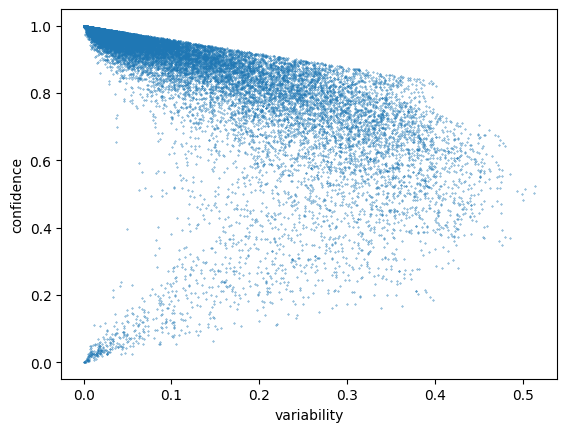

In [ ]:
plt.xlabel('variability')
plt.ylabel('confidence')

sample_size = 25000

np.random.seed(42)
ambiguous_scores_sample = np.random.choice(ambiguous_scores.numpy(), size=sample_size, replace=False)
np.random.seed(42)
hard_scores_sample      = np.random.choice(hard_scores.numpy(),      size=sample_size, replace=False)
plt.scatter(
    ambiguous_scores_sample,
    hard_scores_sample*-1,
    s=0.1)

In [ ]:
plt.hist(hard_scores.numpy()*-1, bins=100)

In [ ]:
plt.hist(ambiguous_scores.numpy(), bins=100)

## Run experiments

In [ ]:
#Synonyms
baseline    = experiment_args['baseline']
num_runs    = experiment_args['num_runs']
num_epochs  = model_args['num_epochs']
fraction    = base_args['fraction']
criterium   = base_args['criterium']
tactic      = curr_args['tactic']
threshold   = curr_args['threshold']
data_name   = data_args['name']


#Do runs with different seeds
for i in range(num_runs):
  seed = random.randint(1, int(1e4))
  set_seed(seed)

  #Print what kind of run this is.
  if baseline:
    if criterium:
      print('Training baseline model with seed '+str(seed)+' and the '+criterium+' '+str(int(fraction*100))+'% of the data.')
    else:
      print('Training baseline model with seed '+str(seed)+' and '+str(int(fraction*100))+'% of the data.')
  else:
    print('Training adaptive curriculum model with seed '+str(seed)+', tactic '+tactic+' and threshold '+str(threshold)+'.')

  #Train a model and calculate metrics for it. Validation metrics are printed during run.
  ft_model, run_metrics = scl_pipeline(tokenized_data, tokenized_ood, data_collator, scores, seed)

  #Cumulate metrics.
  run_metrics = pd.DataFrame(run_metrics)
  cum_metrics = run_metrics if i==0 else cum_metrics+run_metrics
  print('')

#Calculate mean metrics over different seeds.
mean_metrics = (cum_metrics/num_runs).round(3)
mean_metrics.insert(0,'epoch', list(range(1,num_epochs+1))+['test','glue'],True)

#Save metrics for this experimental setup
run_name = generate_experiment_name()
mean_metrics.to_pickle('drive/MyDrive/thesis/experiments/results/'+data_name+'/'+run_name)